Most of this code dervies from the weekly exercise for week 41, and the lecture notes from week 38, 39 and 40. 

Plain gradient descent

Own inversion [[2. ]
 [5. ]
 [0.1]]
Theta from GD: [[2.00079794]
 [4.99794023]
 [0.10099526]]
Theta from GD with l2 regularization: [[2.08607251]
 [4.76123018]
 [0.21778509]]


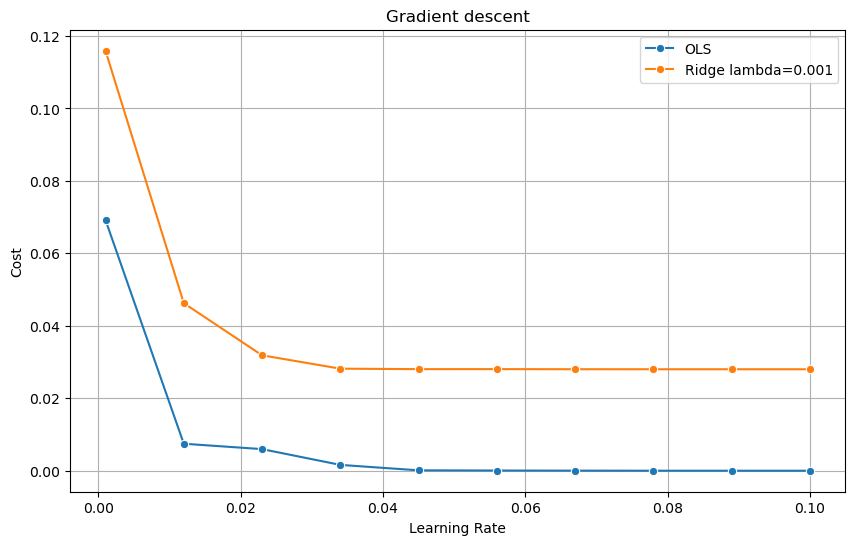

In [226]:
"This part uses a for-loop to identify which learning rate provides the lowest cost for the gradient descent. An L2 regularization is incorporated. This code derive from exercise week 41."

#Importing various packages
import seaborn as sns
import pandas as pd
import autograd.numpy as np 
import matplotlib.pyplot as plt

# Setting random seed for reproducibility
np.random.seed(20)

# Defining the OLS cost functions
def CostOLS(beta):
    return (1.0/n)*np.sum((y-X @ beta)**2)

# Defines the ridge regression cost function
def CostRidge(y, X, beta, lmbda):
   return (1.0/n) * np.sum((y - X @ beta)**2) + lmbda * np.sum(beta**2)


# Generate data
n = 100
x = 2*np.random.rand(n,1)
y = 2.0+5*x+0.1*x*x

# Creates a design matrix
X = np.c_[np.ones((n,1)), x,x*x]

# Matrix inversion
theta_linreg = np.linalg.inv(X.T @ X) @ (X.T @ y)
print("Own inversion", theta_linreg)

# Intervals for the learning rate
eta_values = np.linspace(0.001, 0.1, 10)
Niterations = 3000 #Number of iterations
results_ols = [] # List to collect results
results_ridge = [] # List to collect results

for eta in eta_values:
    # Initialialize random weights
    theta = np.random.randn(3, 1)
   
   # Gradient descent
    for iter in range(Niterations):
        gradients = (2.0 / n) * X.T @ ((X @ theta) - y)
        theta -= eta * gradients
    
    #Calculate cost
    cost = CostOLS(theta)
    results_ols.append([eta, cost, "OLS"])
print("Theta from GD:", theta)




"Adding the L2 regularization"

lmbda = 0.001  # Adding a lambda to include a l2 regularization

for eta in eta_values:
    # Initialialize random weights
    theta = np.random.randn(3, 1)
   
   # Gradient descent
    for iter in range(Niterations):
        gradients = (2.0 / n) * X.T @ ((X @ theta) - y) + 2*lmbda*theta # Ridge regression
        theta -= eta * gradients
    
    #Calculate cost
    cost = CostRidge(y, X, theta, lmbda)
    results_ridge.append([eta, cost, "ridge"])

# Prints the final weights
print("Theta from GD with l2 regularization:", theta)

# Converts the results to a DataFrame
df_ols = pd.DataFrame(results_ols, columns=["eta", "cost", "type"])
df_ridge = pd.DataFrame(results_ridge, columns=["eta", "cost", "type"])

# Plots cost as a function of the learning rate
plt.figure(figsize=(10, 6))
sns.lineplot(x="eta", y="cost", marker="o", data=df_ols, label="OLS")
sns.lineplot(x="eta", y="cost", marker="o", data=df_ridge, label="Ridge lambda=0.001")
plt.title("Gradient descent")
plt.legend()
plt.grid()
plt.xlabel("Learning Rate")
plt.ylabel("Cost")
plt.show()

Gradient Descent with momentum

Own inversion [[2. ]
 [5. ]
 [0.1]]
Theta from GD with momentum: [[2.00000001]
 [4.99999998]
 [0.10000001]]


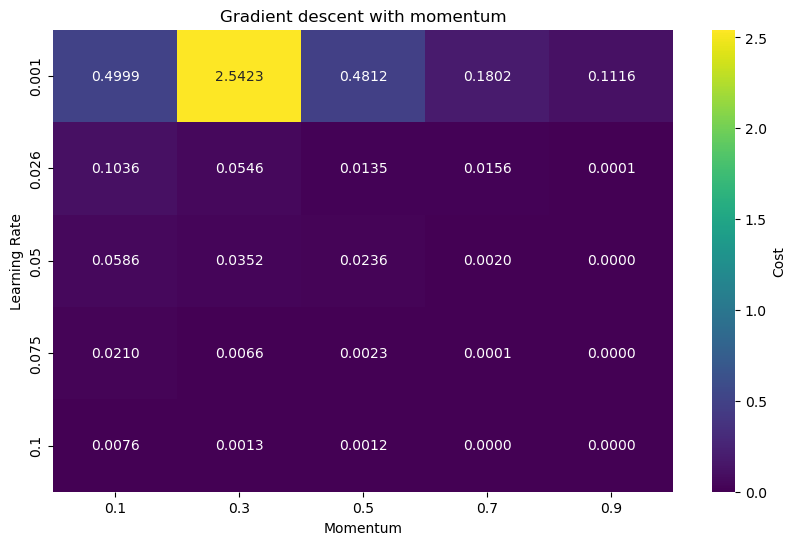

In [ ]:
"This part adds momentum and iters over different combinations of eta of momentum to identify the parameters that results in the lowest cost. Only the OLS cost is used in this part. The gradient descent part of the code derive from exercise week 41. The loops for eta and delta_momentum, and pivot table has been developed with the help of Chat GPT."

# Setting random seed for reproducibility
np.random.seed(20)

# Set ranges for learning rate (eta) and momentum
eta_values = np.round(np.linspace(0.001, 0.1, 5), 3)
momentum_values = np.round(np.linspace(0.1, 0.9, 5), 2) 
Niterations = 550  # Number of iterations
results = [] # Empty list to store results

# Loop over all combinations of eta and momentum
for eta in eta_values:
    for delta_momentum in momentum_values:
        # Initialize random weights for theta
        theta = np.random.randn(3, 1)
        change = 0.0  # Initialize change for momentum to zero

        # Gradient Descent with Momentum
        for iter in range(Niterations):
            # Calculate gradient
            n = len(y)
            gradients = (2.0 / n) * X.T @ ((X @ theta) - y)
            # Calculate the update with momentum
            new_change = eta * gradients + delta_momentum * change
            # Take a step
            theta -= new_change
            # Save the change for the next iteration
            change = new_change
        
        # Calculate cost and store the result
        cost = CostOLS(theta)
        results.append([eta, delta_momentum, cost])

# Prints the thetas for comparison
print("Own inversion", theta_linreg)
print("Theta from GD with momentum:", theta)

# Convert results to a DataFrame
df_results = pd.DataFrame(results, columns=["eta", "delta_momentum", "cost"])

# Creates a pivot table for plotting
df_pivot = df_results.pivot(index="eta", columns="delta_momentum", values="cost")

# Plot the heatmap of cost as a function of learning rate and momentum
plt.figure(figsize=(10, 6))
sns.heatmap(df_pivot, annot=True, cmap="viridis", cbar_kws={'label': 'Cost'}, fmt=".4f")
plt.title("Gradient descent with momentum")
plt.xlabel("Momentum")
plt.ylabel("Learning Rate")
plt.show()

Stochastic gradient descent

Own inversion [[2. ]
 [5. ]
 [0.1]]
theta from own sdg [[2.18624775]
 [4.52636859]
 [0.33034893]]
theta from own sdg with ridge regression [[2.40206514]
 [3.94124454]
 [0.61375533]]


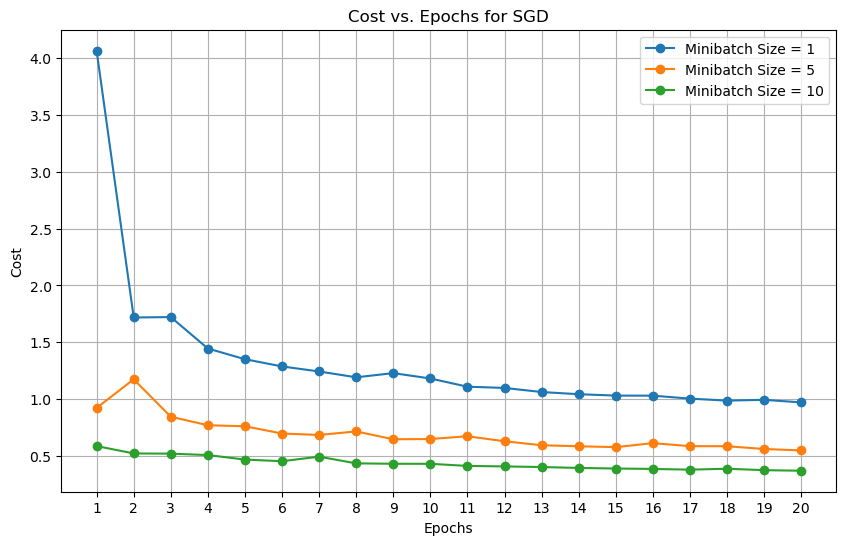

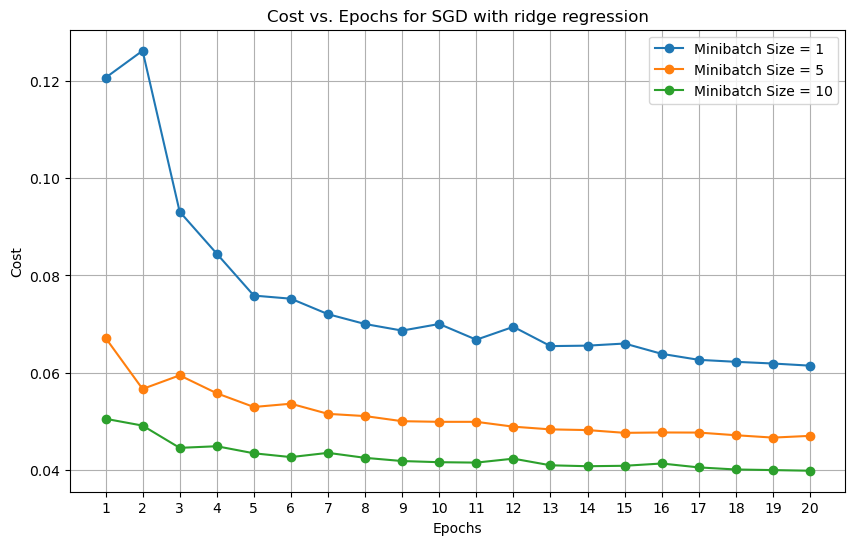

In [ ]:
"This part adds calculates the cost as a function of minibatch size and epochs for SGD. It is also incoporated a learning schedule. This code derive from exercise week 41 and lecture notes week 39."

# Importing various packages
from math import exp, sqrt
from random import random, seed
import autograd.numpy as np 
import matplotlib.pyplot as plt

# Setting random seed for reproducibility
np.random.seed(20)

#Defining the OLS cost function
def CostOLS(y,X,theta):
    return np.sum((y-X @ theta)**2)

# Defines the ridge regression cost function
def CostRidge(y, X, beta, lmbda):
   n = len(y)
   return (1.0/n) * np.sum((y - X @ beta)**2) + lmbda * np.sum(beta**2)

# Generate data
n = 100
x = 2*np.random.rand(n,1)
y = 2.0+5*x+0.1*x*x

# Creates a design matrix
X = np.c_[np.ones((n,1)), x,x*x]

# Matrix inversion
theta_linreg = np.linalg.inv(X.T @ X) @ (X.T @ y)
print("Own inversion", theta_linreg)


n_epochs = 20 # Number of epochs
t0, t1 = 5, 50  # Learning rate schedule parameters
theta = np.random.randn(3, 1) # Initialize weights

# Defining the learning schedule, Lecture notes week 39
def learning_schedule(t):
    return t0/(t+t1)


# Initialize lists to store results for plotting
epoch_results_ols = []
epoch_results_ridge = []


# Loop over minibatch-sizes, uses M = 1,5, and 10
for M in [1, 5, 10]:
    m = int(n / M)
    cost_per_epoch_ols = []

    # Loop over epochs
    for epoch in range(n_epochs):   #Lecture notes week 39
        for i in range(m):
            random_index = M * np.random.randint(m)
            xi = X[random_index:random_index + M]
            yi = y[random_index:random_index + M]
            gradients = (2.0 / M) * xi.T @ ((xi @ theta) - yi) 
            eta = learning_schedule(epoch*m +1)
            theta -= eta * gradients
        
        # Calulates the cost
        cost_ols = CostOLS(y, X, theta)
        cost_per_epoch_ols.append(cost_ols)

    # Store the results for plotting
    epoch_results_ols.append((M, cost_per_epoch_ols))
print("theta from own sdg", theta)


# Sets values for lambda
lmbda = 0.001
theta = np.random.randn(3, 1) # Initialize weights

# Loop over minibatch-sizes, uses M = 1,5, and 10
for M in [1, 5, 10]:
    m = int(n / M)
    cost_per_epoch_ridge = []

    # Loop over epochs
    for epoch in range(n_epochs):   #Lecture notes week 39
        for i in range(m):
            random_index = M * np.random.randint(m)
            xi = X[random_index:random_index + M]
            yi = y[random_index:random_index + M]
            gradients = (2.0 / M) * xi.T @ ((xi @ theta) - yi) +  2*lmbda*theta
            eta = learning_schedule(epoch*m +1)
            theta -= eta * gradients
        
        # Calulates the cost
        cost_ridge = CostRidge(y, X, theta, lmbda)
        cost_per_epoch_ridge.append(cost_ridge)

    # Store the results for plotting
    epoch_results_ridge.append((M, cost_per_epoch_ridge))
print("theta from own sdg with ridge regression", theta)

# Plots the cost as a function of epochs and mini-batch sizes
plt.figure(figsize=(10, 6))
for M, costs in epoch_results_ols:
    plt.plot(range(1, n_epochs+1), costs, marker='o', label=f"Minibatch Size = {M}")

plt.title("Cost vs. Epochs for SGD")
plt.xlabel("Epochs")
plt.ylabel("Cost")
plt.xticks(range(1, n_epochs + 1)) # To include all the epochs
plt.grid()
plt.legend()
plt.show()

# Plots the cost as a function of epochs and mini-batch sizes
plt.figure(figsize=(10, 6))
for M, costs in epoch_results_ridge:
    plt.plot(range(1, n_epochs+1), costs, marker='o', label=f"Minibatch Size = {M}")

plt.title("Cost vs. Epochs for SGD with ridge regression")
plt.xlabel("Epochs")
plt.ylabel("Cost")
plt.grid()
plt.xticks(range(1, n_epochs + 1)) # To include all the epochs
plt.legend()
plt.show()

Stochastic gradient descent with momentum

Own inversion [[2. ]
 [5. ]
 [0.1]]
theta from gd wth momentum [[2.0257288 ]
 [4.92860399]
 [0.13246577]]


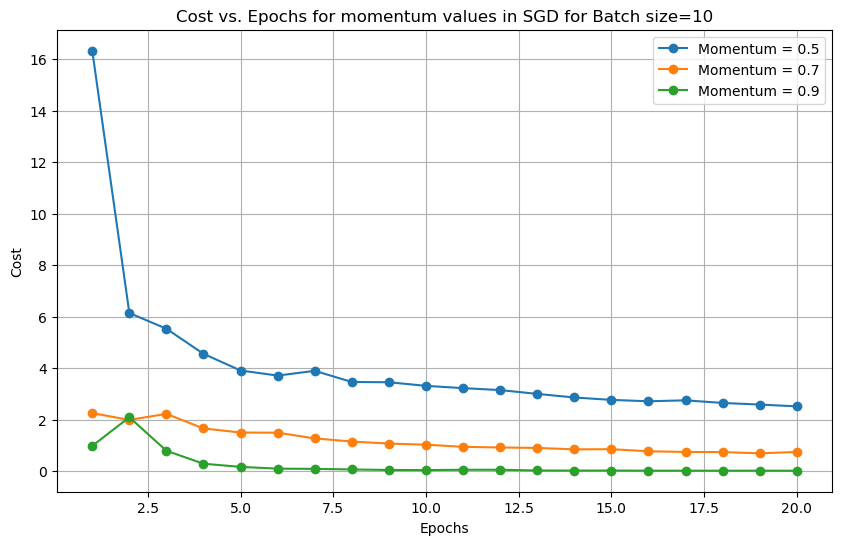

In [249]:
"This code implements momentum to the SGD, and loops over different momentum values"

# Setting random seed for reproducibility
np.random.seed(20)

#Defining the cost function
def CostOLS(y,X,theta):
    return np.sum((y-X @ theta)**2)

# Generate data
n = 100
x = 2*np.random.rand(n,1)
y = 2.0+5*x+0.1*x*x

# Creates a design matrix
X = np.c_[np.ones((n,1)), x,x*x]

# Matrix inversion
theta_linreg = np.linalg.inv(X.T @ X) @ (X.T @ y)
print("Own inversion", theta_linreg)

M = 10  #size of each minibatch
m = int(n/M) #number of minibatches
theta = np.random.randn(3, 1) # Initialize the weights
n_epochs = 20 # Number of epochs

# Defining the learning schedule, Lecture notes week 39
def learning_schedule(t):
    return t0/(t+t1)

t0, t1 = 5, 50  # Learning rate schedule parameters

# Different values for delta momentum
delta_momentum_values = [0.5,0.7,0.9]
momentum_results = []

# Loop over different delta momentum values
for delta_momentum in delta_momentum_values:
    change = np.zeros_like(theta) 
    cost_per_epoch = []
    # Loop over epochs
    for epoch in range(n_epochs):
        for i in range(m):
            # Randomly selects minibatches
            random_index = M * np.random.randint(m)
            xi = X[random_index:random_index + M]
            yi = y[random_index:random_index + M]
            # Calculate gradient
            gradients = (2.0 / M) * xi.T @ ((xi @ theta) - yi)
            eta = learning_schedule(epoch*m +1)
            # calculate update
            change = eta*gradients+delta_momentum*change
            # Update weights
            theta -= change
        
        # Calculate cost and storing the results
        cost = CostOLS(y, X, theta)
        cost_per_epoch.append(cost)
    momentum_results.append((delta_momentum, cost_per_epoch))
print("theta from gd wth momentum", theta)

# Plots cost vs. epochs for different values
plt.figure(figsize=(10, 6))
for momentum, costs in momentum_results:
    plt.plot(range(1, n_epochs + 1), costs, marker='o', label=f"Momentum = {momentum}")

plt.title("Cost vs. Epochs for momentum values in SGD for Batch size=10")
plt.xlabel("Epochs")
plt.ylabel("Cost")
plt.grid()
plt.legend()
plt.show()

Gradient descent with RMSprop

Own inversion: [[2. ]
 [5. ]
 [0.1]]


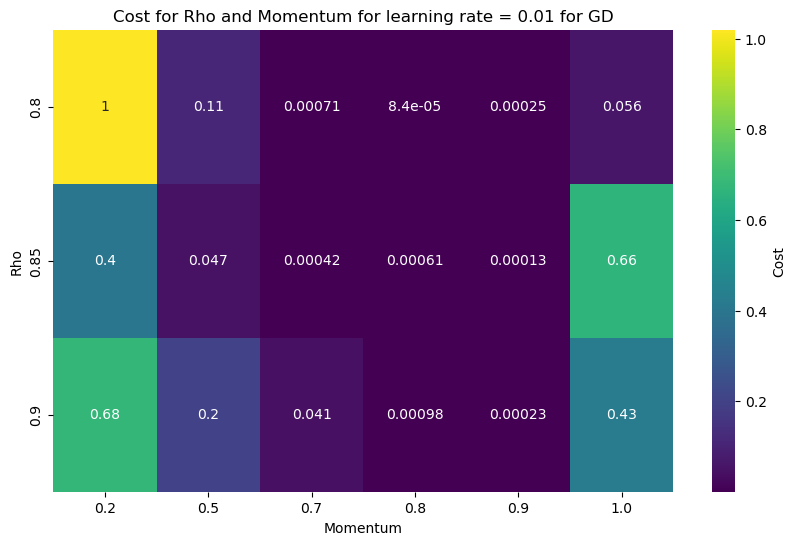

In [271]:
"This part implements RMSprop to the Gradient Descent with OLS cost function. It loops over differens values for learning rate, rho and momentum and plots a heatmap of the results."

# Importing necessary packages
import autograd.numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

# Setting random seed for reproducibility
np.random.seed(20)

# Define the cost function
def CostOLS(theta, X):
    return (1.0 / n) * np.sum((y - X @ theta) ** 2)

# Generate data
n = 100
x = 2 * np.random.rand(n, 1)
y = 2.0 + 5 * x + 0.1 * x * x

# Create a design matrix 
X = np.c_[np.ones((n, 1)), x, x * x]

# Calculate the analytical solution
theta_linreg = np.linalg.inv(X.T @ X) @ (X.T @ y)
print("Own inversion:", theta_linreg)

# Initialize parameters
n_epochs = 200
eta_values = [0.001,0.01, 0.05, 0.1,0.9] # Values for learning rate
rho_values = [0.8, 0.85, 0.9] # Values for Rho
momentum_values = [0.2,0.5,0.7, 0.8, 0.9,1] # Momentum values
delta = 1e-6
theta = np.random.randn(3, 1)

# Store results for plotting
results = []

# Loop over eta, rho, and momentum values
for eta in eta_values:
    for rho in rho_values:
        for delta_momentum in momentum_values:
            theta = np.random.randn(3, 1)
            Giter = np.zeros_like(theta)
            change = np.zeros_like(theta)

            # RMSprop with momentum
            for epoch in range(n_epochs):
                gradients = (2.0 / n) * X.T @ ((X @ theta) - y)
                Giter = rho * Giter + (1 - rho) * gradients ** 2
                adjusted_gradients = gradients * eta / (delta + np.sqrt(Giter))
                new_change = delta_momentum * change - adjusted_gradients
                theta += new_change
                change = new_change

            # Calculate final cost
            final_cost = CostOLS(theta, X)
            results.append([eta, rho, delta_momentum, final_cost])


# Convert results to a DataFrame
df_results = pd.DataFrame(results, columns=["eta", "rho", "momentum", "cost"])

# Finds the eta with the lowest cost-value, this is used to visualize rho, momentum and cost
best_eta = eta_values[np.argmin(df_results.groupby("eta")["cost"].min())]
df_filtered = df_results[df_results["eta"] == best_eta]


# Create a pivot table 
pivot_df = df_filtered.pivot(index="rho", columns="momentum", values="cost")


# Plotting the heatmap
plt.figure(figsize=(10, 6))
sns.heatmap(pivot_df, annot=True, cmap="viridis", cbar_kws={'label': 'Cost'})
plt.title(f"Cost for Rho and Momentum for learning rate = {best_eta} for GD")
plt.xlabel("Momentum")
plt.ylabel("Rho")
plt.show()

Own inversion: [[2. ]
 [5. ]
 [0.1]]
theta from GD with RMSprop [[1.5585989 ]
 [3.10617375]
 [1.01432693]]


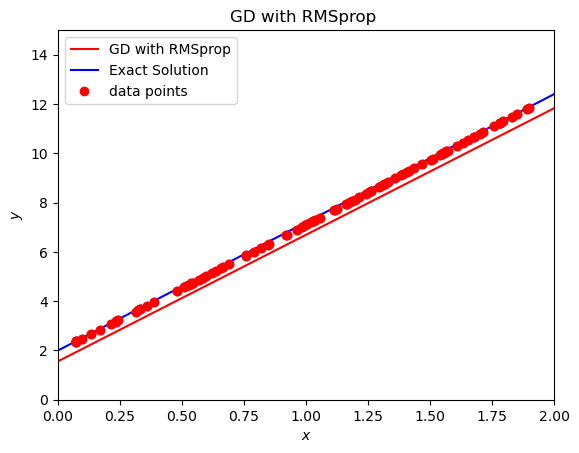

theta from GD wth momentum and RMSprop [[2.00528271]
 [4.99656895]
 [0.10594438]]


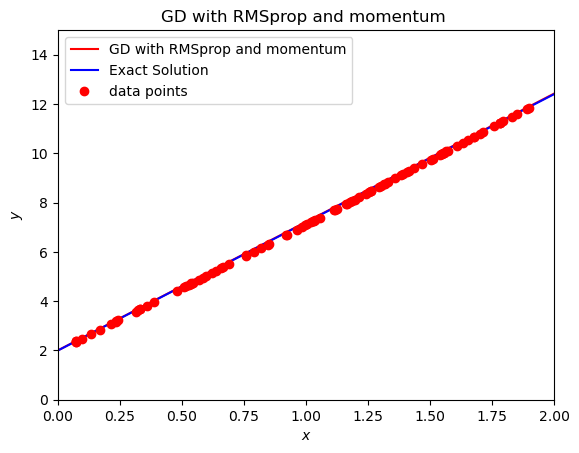

In [272]:
"The results from the heatmap is used in the RMSprop"

# Importing necessary packages
import autograd.numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

# Setting random seed for reproducibility
np.random.seed(20)

# Define the cost function
def CostOLS(theta, X):
    return (1.0 / n) * np.sum((y - X @ theta) ** 2)

# Generate data
n = 100
x = 2 * np.random.rand(n, 1)
y = 2.0 + 5 * x + 0.1 * x * x

# Create a design matrix with a column of ones
X = np.c_[np.ones((n, 1)), x, x * x]

# Calculate the analytical solution
theta_linreg = np.linalg.inv(X.T @ X) @ (X.T @ y)
print("Own inversion:", theta_linreg)

# Initialize parameters, uses the values from the heatmap
n_epochs = 200
eta = 0.01
rho = 0.8
delta = 1e-6
momentum = 0.8

# Initialize weights
theta = np.random.randn(3, 1)
Giter = np.zeros_like(theta)
change = np.zeros_like(theta)

# Gradient descent with RMSprop
for epoch in range(n_epochs):
        gradients = (2.0 / n) * X.T @ ((X @ theta) - y)
        Giter = rho*Giter+(1-rho)*gradients*gradients
        adjusted_gradients = gradients*eta/(delta+np.sqrt(Giter))
        theta -= adjusted_gradients

print("theta from GD with RMSprop", theta)

# Predictions
xnew = np.array([[0],[2]])
Xnew = np.c_[np.ones((2,1)), xnew, xnew*xnew]
ypredict = Xnew.dot(theta)
ypredict2 = Xnew.dot(theta_linreg)

# Plots the predictions
plt.plot(xnew, ypredict, "r-", label="GD with RMSprop")
plt.plot(xnew, ypredict2, "b-", label="Exact Solution")
plt.plot(x, y ,'ro', label="data points")
plt.plot(x, y ,'ro')
plt.legend()
plt.axis([0,2.0,0, 15.0])
plt.xlabel(r'$x$')
plt.ylabel(r'$y$')
plt.title(r'GD with RMSprop ')
plt.show()


# Initialize the weights, Giter and change 
theta = np.random.randn(3, 1)
Giter = np.zeros_like(theta)
change = np.zeros_like(theta)


# Run the RMSprop and momentum using the best values
for epoch in range(n_epochs):
    gradients = (2.0 / n) * X.T @ ((X @ theta) - y)
    Giter = rho * Giter + (1 - rho) * (gradients * gradients)
    adjusted_gradients = gradients * eta / (delta + np.sqrt(Giter))
    new_change = momentum * change - adjusted_gradients
    theta += new_change
    change = new_change

print("theta from GD wth momentum and RMSprop", theta)

# Predictions and plots
xnew = np.array([[0],[2]])
Xnew = np.c_[np.ones((2,1)), xnew, xnew*xnew]
ypredict = Xnew.dot(theta)
ypredict2 = Xnew.dot(theta_linreg)

plt.plot(xnew, ypredict, "r-", label="GD with RMSprop and momentum")
plt.plot(xnew, ypredict2, "b-", label="Exact Solution")
plt.plot(x, y ,'ro', label="data points")
plt.axis([0,2.0,0, 15.0])
plt.legend()
plt.xlabel(r'$x$')
plt.ylabel(r'$y$')
plt.title(r'GD with RMSprop and momentum ')
plt.show()


Stochastic Gradient Descent with RMSprop

Own inversion [[2. ]
 [5. ]
 [0.1]]


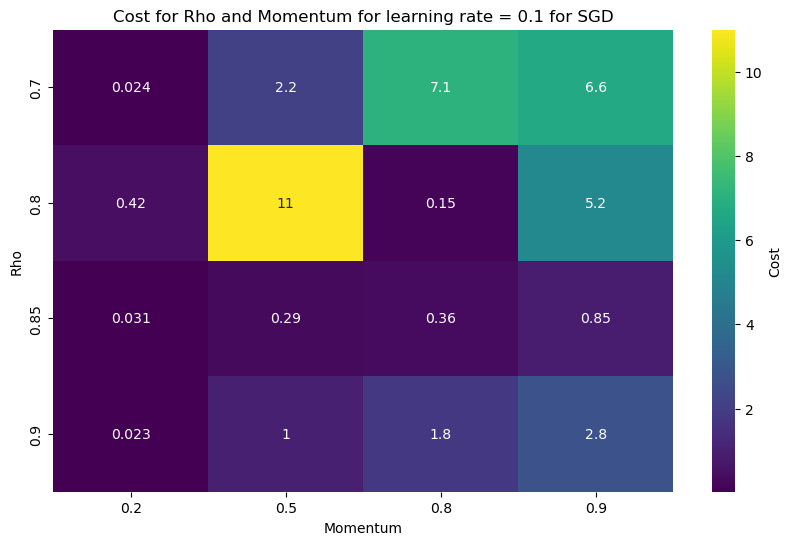

In [274]:
"This part implements RMSprop to the Stochastic Gradient Descent with OLS cost function. It loops over differens values for learning rate, rho and momentum and plots a heatmap of the results."

# Importing various packages
from math import exp, sqrt
from random import random, seed
import autograd.numpy as np 
import matplotlib.pyplot as plt

# Setting random seed for reproducibility
np.random.seed(20)

#Defining the cost function
def CostOLS(y,X,theta):
    return np.sum((y-X @ theta)**2)

# Generate data
n = 100
x = 2*np.random.rand(n,1)
y = 2.0+5*x+0.1*x*x

# Creates a design matrix
X = np.c_[np.ones((n,1)), x,x*x]

# Matrix inversion
theta_linreg = np.linalg.inv(X.T @ X) @ (X.T @ y)
print("Own inversion", theta_linreg)

# Hyperparameter ranges
rho_values = [0.7, 0.8, 0.85, 0.9]
delta_values = [0.5, 0.7, 0.8, 0.9]
momentum_values = [0.2, 0.5, 0.8,0.9]

# Fixed parameters
n_epochs = 200
M = 10
m = int(n / M)
eta = 0.1 # Fixed learning rate
delta = 1e-6
# Store results
results = []

# Loop over rho, delta, and momentum
for rho in rho_values:
    for momentum in momentum_values:
        # Initialize the weights, Giter and change
        theta = np.random.randn(3, 1)
        Giter = np.zeros_like(theta)
        change = np.zeros_like(theta)

        # RMSprop and momentum
        for epoch in range(n_epochs):
            for i in range(m):
                # Selects random batches
                random_index = M * np.random.randint(m)
                xi = X[random_index:random_index + M]
                yi = y[random_index:random_index + M]
                # Calculates the gradients
                gradients = (2.0 / M) * xi.T @ ((xi @ theta) - yi)
                Giter = rho * Giter + (1 - rho) * gradients ** 2
                adjusted_gradients = gradients * eta / (delta + np.sqrt(Giter))
                new_change = momentum * change - adjusted_gradients
                theta += new_change
                change = new_change

        # Calculate final cost
        final_cost = CostOLS(y, X,theta)
        results.append([rho, momentum, final_cost])

# Convert results to DataFrame
df_results = pd.DataFrame(results, columns=["rho", "momentum", "cost"])

# Creates a Pivot table
pivot_df = df_results.pivot_table(index="rho", columns="momentum", values="cost")

# Plots the cost as a function of Rho and momentum
plt.figure(figsize=(10, 6))
sns.heatmap(pivot_df, annot=True, cmap="viridis", cbar_kws={'label': 'Cost'})
plt.title(f"Cost for Rho and Momentum for learning rate = {eta} for SGD")
plt.xlabel("Momentum")
plt.ylabel("Rho")
plt.show()

Own inversion: [[2. ]
 [5. ]
 [0.1]]

Theta from SGD with RMSprop: [[1.98636975]
 [5.02984628]
 [0.08605312]]


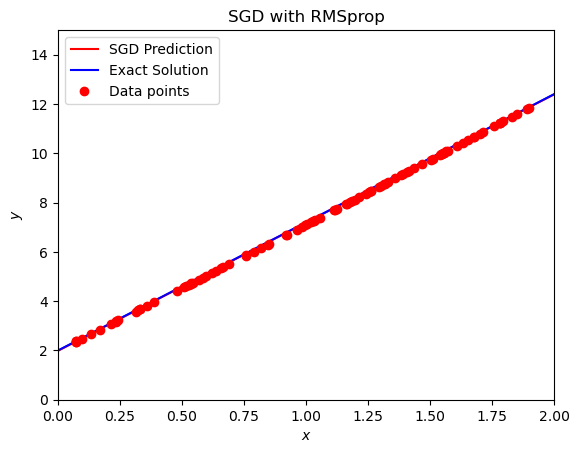


Theta from SGD with RMSprop and momentum: [[2.05253171]
 [5.06922181]
 [0.14105166]]


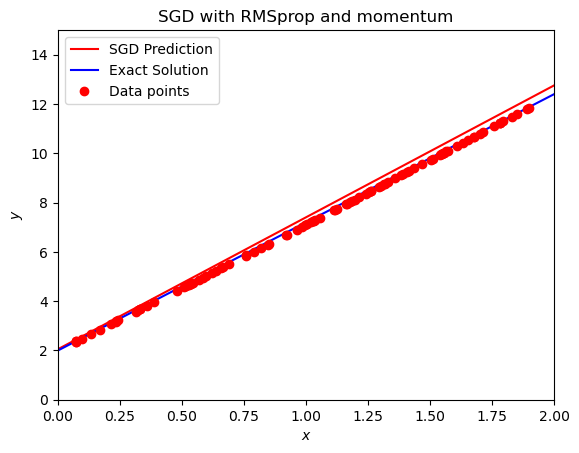

In [277]:
# Import necessary packages
import autograd.numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns

np.random.seed(20)

# Define the cost function
def CostOLS(theta, X, y):
    return np.sum((y - X @ theta) ** 2)

# Generate data
n = 100
x = 2 * np.random.rand(n, 1)
y = 2.0 + 5 * x + 0.1 * x * x
X = np.c_[np.ones((n, 1)), x, x * x]

# Analytical solution
theta_linreg = np.linalg.inv(X.T @ X) @ (X.T @ y)
print("Own inversion:", theta_linreg)

# Fixed parameters
n_epochs = 200
M = 10
m = int(n / M)
eta = 0.1
theta = np.random.randn(3, 1)
Giter = np.zeros_like(theta)
change = np.zeros_like(theta)
delta = 1e-6
momentum = 0.2
rho = 0.9

for epoch in range(n_epochs):
    for i in range(m):
        random_index = M * np.random.randint(m)
        xi = X[random_index:random_index + M]
        yi = y[random_index:random_index + M]
        gradients = (2.0 / M) * xi.T @ ((xi @ theta) - yi)
        Giter = rho * Giter + (1 - rho) * gradients * gradients
        adjusted_gradients = gradients * eta / (delta + np.sqrt(Giter))
        theta -= adjusted_gradients

print("\nTheta from SGD with RMSprop:", theta)

# Predictions and final plot
xnew = np.array([[0], [2]])
Xnew = np.c_[np.ones((2, 1)), xnew, xnew * xnew]
ypredict = Xnew.dot(theta)
ypredict2 = Xnew.dot(theta_linreg)

# Plot predictions
plt.plot(xnew, ypredict, "r-", label="SGD Prediction")
plt.plot(xnew, ypredict2, "b-", label="Exact Solution")
plt.plot(x, y, 'ro', label="Data points")
plt.axis([0, 2.0, 0, 15.0])
plt.xlabel(r'$x$')
plt.ylabel(r'$y$')
plt.title(r'SGD with RMSprop')
plt.legend()
plt.show()


for epoch in range(n_epochs):
    for i in range(m):
        random_index = M * np.random.randint(m)
        xi = X[random_index:random_index + M]
        yi = y[random_index:random_index + M]
        gradients = (2.0 / M) * xi.T @ ((xi @ theta) - yi)
        Giter = rho * Giter + (1 - rho) * gradients ** 2
        adjusted_gradients = gradients * eta / (delta + np.sqrt(Giter))
        new_change = momentum * change - adjusted_gradients
        theta += new_change
        change = new_change

print("\nTheta from SGD with RMSprop and momentum:", theta)

# Predictions and final plot
xnew = np.array([[0], [2]])
Xnew = np.c_[np.ones((2, 1)), xnew, xnew * xnew]
ypredict = Xnew.dot(theta)
ypredict2 = Xnew.dot(theta_linreg)

# Plot predictions
plt.plot(xnew, ypredict, "r-", label="SGD Prediction")
plt.plot(xnew, ypredict2, "b-", label="Exact Solution")
plt.plot(x, y, 'ro', label="Data points")
plt.axis([0, 2.0, 0, 15.0])
plt.xlabel(r'$x$')
plt.ylabel(r'$y$')
plt.title(r'SGD with RMSprop and momentum')
plt.legend()
plt.show()

Gradient Descent with AdaGrad

Own inversion: [[2. ]
 [5. ]
 [0.1]]
theta from GD with AdaGrad
[[2.52710402]
 [3.60250688]
 [0.78331926]]


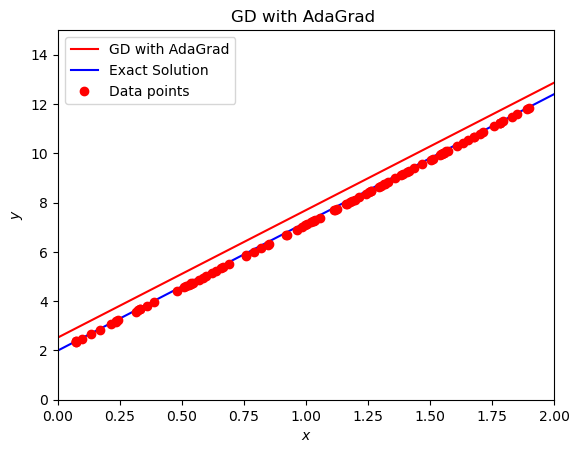

theta from gd wth momentum and AdaGrad [[1.99757296]
 [5.00630977]
 [0.09692147]]


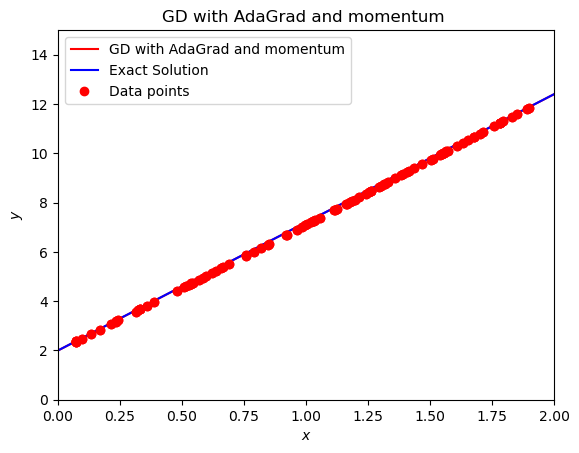

In [285]:
"This section implements AdaGrad to the Gradient Descent"

#Importing various packages
from random import random, seed
import autograd.numpy as np 
import matplotlib.pyplot as plt

# Setting random seed for reproducibility
np.random.seed(20)

# Define the cost function
def CostOLS(theta, X, y):
    return np.sum((y - X @ theta) ** 2)

# Generate data
n = 100
x = 2 * np.random.rand(n, 1)
y = 2.0 + 5 * x + 0.1 * x * x

# Creates a design matrix
X = np.c_[np.ones((n, 1)), x, x * x]

# Analytical solution
theta_linreg = np.linalg.inv(X.T @ X) @ (X.T @ y)
print("Own inversion:", theta_linreg)

n_epochs = 200 # Number of epochs
eta = 0.9 # Fixed learning rate
delta_momentum = 0.9 
delta = 1e-6
theta = np.random.randn(3,1) # Initialize weights
Giter = np.zeros_like(theta) 

# Loop over epochs
for epoch in range(n_epochs):
        gradients =  (2.0 / n) * X.T @ ((X @ theta) - y)
        Giter += gradients*gradients
         # AdaGrad adjustment
        adjusted_gradients = gradients*eta/(delta+np.sqrt(Giter))
        # calculate update
        theta -= adjusted_gradients

print("theta from GD with AdaGrad")
print(theta)

# Predictions
xnew = np.array([[0],[2]])
Xnew = np.c_[np.ones((2,1)), xnew, xnew*xnew]
ypredict = Xnew.dot(theta)
ypredict2 = Xnew.dot(theta_linreg)

plt.plot(xnew, ypredict, "r-", label="GD with AdaGrad")
plt.plot(xnew, ypredict2, "b-", label="Exact Solution")
plt.plot(x, y, 'ro', label="Data points")
plt.axis([0,2.0,0, 15.0])
plt.legend()
plt.xlabel(r'$x$')
plt.ylabel(r'$y$')
plt.title(r'GD with AdaGrad ')
plt.show()


#Now improve with momentum gradient descent and AdaGrad
change = np.zeros_like(theta)
Giter = np.zeros_like(theta) 

# Loop over epochs
for epoch in range(n_epochs):
    # calculate gradient
    gradients =  (2.0 / n) * X.T @ ((X @ theta) - y)
    Giter += gradients*gradients
    # AdaGrad adjustment
    adjusted_gradients = gradients*eta/(delta+np.sqrt(Giter))
    # calculate update
    change = delta_momentum * change - adjusted_gradients
    # Update theta
    theta += change

print("theta from gd wth momentum and AdaGrad", theta)

# Predictions
xnew = np.array([[0],[2]])
Xnew = np.c_[np.ones((2,1)), xnew, xnew*xnew]
ypredict = Xnew.dot(theta)
ypredict2 = Xnew.dot(theta_linreg)

# Plots the result
plt.plot(xnew, ypredict, "r-", label="GD with AdaGrad and momentum")
plt.plot(xnew, ypredict2, "b-", label="Exact Solution")
plt.plot(x, y, 'ro', label="Data points")
plt.plot(x, y ,'ro')
plt.axis([0,2.0,0, 15.0])
plt.legend()
plt.xlabel(r'$x$')
plt.ylabel(r'$y$')
plt.title(r'GD with AdaGrad and momentum ')
plt.show()

Stochastic Gradient Descent with Adagrad

Own inversion: [[2. ]
 [5. ]
 [0.1]]
theta from SDG with AdaGrad
[[2.11991201]
 [4.68602945]
 [0.25574135]]


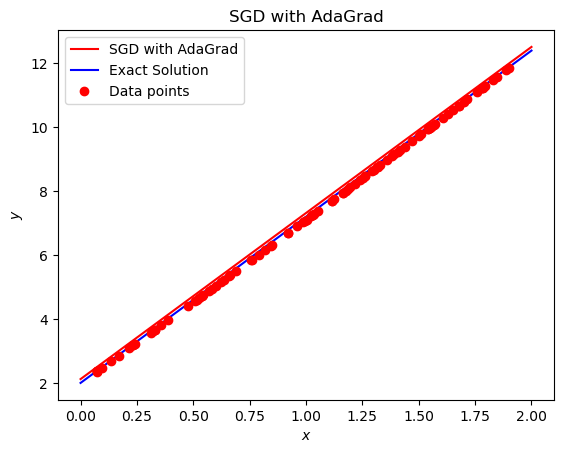

theta from sdg with momentum and AdaGrad
[[2.00000005]
 [4.99999989]
 [0.10000005]]


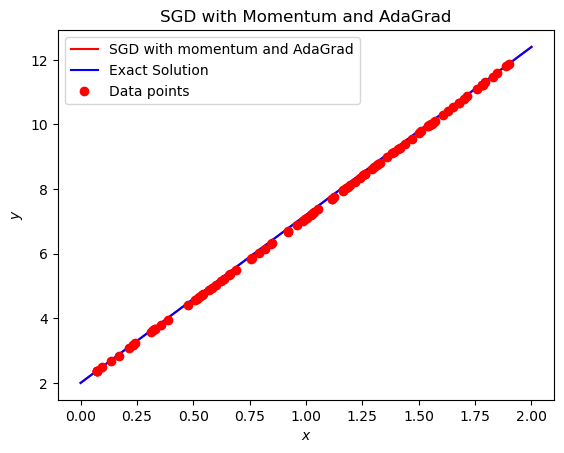

In [286]:
"This section implements AdaGrad to the Stochastic Gradient Descent"

#Importing various packages
import autograd.numpy as np 
import matplotlib.pyplot as plt


# Setting random seed for reproducibility
np.random.seed(20)

# Define the cost function
def CostOLS(theta, X, y):
    return np.sum((y - X @ theta) ** 2)

# Generate data
n = 100
x = 2 * np.random.rand(n, 1)
y = 2.0 + 5 * x + 0.1 * x * x

# Creates a design matrix
X = np.c_[np.ones((n, 1)), x, x * x]

# Analytical solution
theta_linreg = np.linalg.inv(X.T @ X) @ (X.T @ y)
print("Own inversion:", theta_linreg)

n_epochs = 200 #Number of epochs
eta = 0.9 #Fixed learning rate
delta_momentum = 0.9
delta = 1e-6
M = 10 #Batch size
m = int(n/M)
theta = np.random.randn(3,1)
Giter = np.zeros_like(theta)

# Loop over epochs
for epoch in range(n_epochs):
    for i in range(m):
        random_index = M*np.random.randint(m)
        xi = X[random_index:random_index+M]
        yi = y[random_index:random_index+M]
        # AdaGrad with SGD
        gradients = (1.0/M)* xi.T @ ((xi @ theta)-yi)
        Giter += gradients*gradients
        update = gradients*eta/(delta+np.sqrt(Giter))
        theta -= update
print("theta from SDG with AdaGrad")
print(theta)


# Predictions
xnew = np.array([[0],[2]])
Xnew = np.c_[np.ones((2,1)), xnew, xnew*xnew]
ypredict = Xnew.dot(theta)
ypredict2 = Xnew.dot(theta_linreg)


plt.plot(xnew, ypredict, "r-", label="SGD with AdaGrad")
plt.plot(xnew, ypredict2, "b-", label="Exact Solution")
plt.plot(x, y, 'ro', label="Data points")
plt.xlabel(r'$x$')
plt.ylabel(r'$y$')
plt.legend()
plt.title(r'SGD with AdaGrad')
plt.show()

# Reinitialize parameters for AdaGrad with momentum
change = np.zeros_like(theta)  # Initialize change for momentum
Giter = np.zeros_like(theta)  # Reset AdaGrad accumulator
theta = np.random.randn(3,1) # Initialize the weights

# Loop over epochs
for epoch in range(n_epochs):
    for i in range(m):
        random_index = M*np.random.randint(m)
        xi = X[random_index:random_index+M]
        yi = y[random_index:random_index+M]
        # AdaGrad with SGD and momentum
        gradients = (1.0/M)* xi.T @ ((xi @ theta)-yi)
        Giter += gradients*gradients
        adjusted_gradients = eta * gradients / (delta + np.sqrt(Giter))
        new_change = delta_momentum * change - adjusted_gradients
        theta += new_change
        change = new_change
print("theta from sdg with momentum and AdaGrad")
print(theta)

# Predictions
xnew = np.array([[0],[2]])
Xnew = np.c_[np.ones((2,1)), xnew, xnew*xnew]
ypredict = Xnew.dot(theta)
ypredict2 = Xnew.dot(theta_linreg)

# Plot predictions for AdaGrad and momentum
plt.plot(xnew, ypredict, "r-", label="SGD with momentum and AdaGrad")
plt.plot(xnew, ypredict2, "b-", label="Exact Solution")
plt.plot(x, y, 'ro', label="Data points")
plt.xlabel(r'$x$')
plt.ylabel(r'$y$')
plt.legend()
plt.title(r'SGD with Momentum and AdaGrad')
plt.show()


GD with Adam

Own inversion [[2. ]
 [5. ]
 [0.1]]
theta from GD with Adam
[[2.0038138 ]
 [4.99000649]
 [0.1048625 ]]


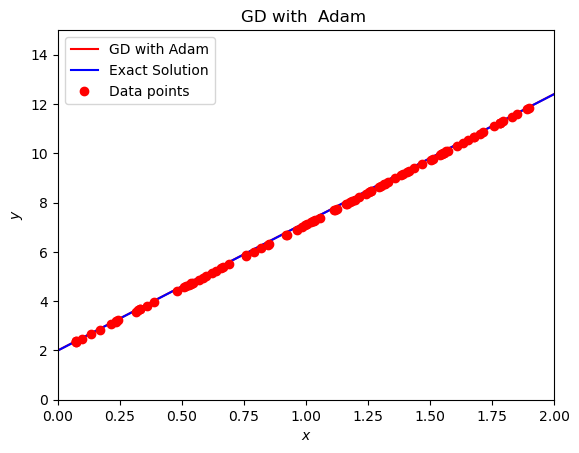

In [ ]:
" This sections implements the Adam optimizer to the GD"

# Importing various packages
import autograd.numpy as np 
import matplotlib.pyplot as plt

# Setting random seed for reproducibility
np.random.seed(20)

#Defining the cost function
def CostOLS(y,X,theta):
    return np.sum((y-X @ theta)**2)

# Generate data
n = 100
x = 2*np.random.rand(n,1)
y = 2.0+5*x+0.1*x*x

# Creates a design matrix
X = np.c_[np.ones((n,1)), x,x*x]

# Matrix inversion
theta_linreg = np.linalg.inv(X.T @ X) @ (X.T @ y)
print("Own inversion", theta_linreg)


n_epochs = 500 # Number of epochs
theta = np.random.randn(3,1) # Initialize weights
eta = 0.9 # The learning rate
delta  = 1e-6 # Small value to prevent deviation of zero

# The parameters beta1 and 2
beta1 = 0.9
beta2= 0.999

first_moment = np.zeros_like(theta)
second_moment = np.zeros_like(theta)

# Adam loop
for epoch in range(n_epochs):
        gradients = (2.0 / n) * X.T @ ((X @ theta) - y)
        first_moment = beta1*first_moment + (1-beta1)*gradients
        second_moment = beta2*second_moment + (1-beta2)*gradients*gradients
        # Bias correction
        first_term = first_moment/(1.0-beta1**(epoch+1))
        second_term = second_moment/(1-beta2**(epoch+1))
        update = first_term*eta/(delta+np.sqrt(second_term))
        theta -= update

print("theta from GD with Adam")
print(theta)

# Predictions
xnew = np.array([[0],[2]])
Xnew = np.c_[np.ones((2,1)), xnew, xnew*xnew]
ypredict = Xnew.dot(theta)
ypredict2 = Xnew.dot(theta_linreg)

plt.plot(xnew, ypredict, "r-", label="GD with Adam")
plt.plot(xnew, ypredict2, "b-", label="Exact Solution")
plt.plot(x, y, 'ro', label="Data points")
plt.axis([0,2.0,0, 15.0])
plt.legend()
plt.xlabel(r'$x$')
plt.ylabel(r'$y$')
plt.title(r'GD with  Adam ')
plt.show()

SDG with ADAM

Own inversion [[2. ]
 [5. ]
 [0.1]]
theta from SDG with Adam
[[2.00293805]
 [4.99055384]
 [0.10431524]]


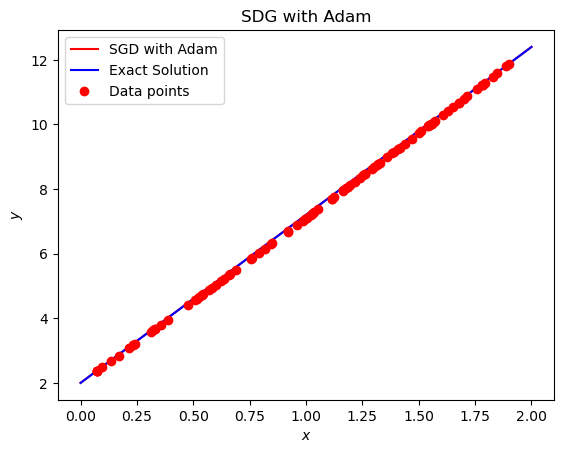

In [299]:
" This sections implements the Adam optimizer to the SGD"

# Importing various packages
import autograd.numpy as np 
import matplotlib.pyplot as plt

# Setting random seed for reproducibility
np.random.seed(20)

#Defining the cost function
def CostOLS(y,X,theta):
    return np.sum((y-X @ theta)**2)

# Generate data
n = 100
x = 2*np.random.rand(n,1)
y = 2.0+5*x+0.1*x*x

# Creates a design matrix
X = np.c_[np.ones((n,1)), x,x*x]

# Matrix inversion
theta_linreg = np.linalg.inv(X.T @ X) @ (X.T @ y)
print("Own inversion", theta_linreg)

#Initalizes random weights for theta
theta = np.random.randn(3,1)

n_epochs = 100 # Epochs
M = 10  #size of each minibatch
m = int(n/M) #number of minibatches
eta = 0.9 # Fixed learning rate

first_moment = np.zeros_like(theta)
second_moment = np.zeros_like(theta)
delta  = 1e-5

# Parameters beta1 and 2
beta1 = 0.9
beta2= 0.999

# Adam opimization
for epoch in range(n_epochs):
    for i in range(m):
        random_index = M*np.random.randint(m)
        xi = X[random_index:random_index+M]
        yi = y[random_index:random_index+M]
        # Calculate the gradients
        gradients = (1.0/M)* xi.T @ ((xi @ theta)-yi)
        first_moment = beta1*first_moment + (1-beta1)*gradients
        second_moment = beta2*second_moment + (1-beta2)*gradients*gradients
        # Bias correction
        first_term = first_moment/(1-beta1**(epoch+1))
        second_term = second_moment/(1-beta2**(epoch+1))
        update = first_term*eta/(delta+np.sqrt(second_term))
        theta -= update
print("theta from SDG with Adam")
print(theta)


# Predictions
xnew = np.array([[0],[2]])
Xnew = np.c_[np.ones((2,1)), xnew, xnew*xnew]
ypredict = Xnew.dot(theta)
ypredict2 = Xnew.dot(theta_linreg)


plt.plot(xnew, ypredict, "r-", label="SGD with Adam")
plt.plot(xnew, ypredict2, "b-", label="Exact Solution")
plt.plot(x, y, 'ro', label="Data points")
plt.legend()
plt.xlabel(r'$x$')
plt.ylabel(r'$y$')
plt.title(r'SDG with Adam')
plt.show()